# Trabajo Práctico 3
## Buscaglia Tomás Enrique - López Fonatanelle Martiniano - Anchorena Ignacio

In [1]:
##Ejercicio 1 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

## 2) 
#a) Importamos la base de datos, y nos quedamos unicamente con las observaciones pertenecientes a a los aglomerados de Ciudad Autónoma de Buenos Aires o Gran Buenos Aires.
df = pd.read_excel("C:/Users/tomas/Documents/UdeSA/Cuarto Año/Primer Cuatri/Big Data/TP3/EPH_usu_4to_Trim_2023_xlsx/usu_individual_T423.xlsx")


df = df[df['AGLOMERADO'].isin([32, 33])]

In [21]:
#b) Eliminamos observaciones con valores atipicos, como edades o tiempo de empleo negativo
df = df[df['CH06'] > 0]
df['MAS_500'] = np.where(df['MAS_500'] == 'S', 1, 0)


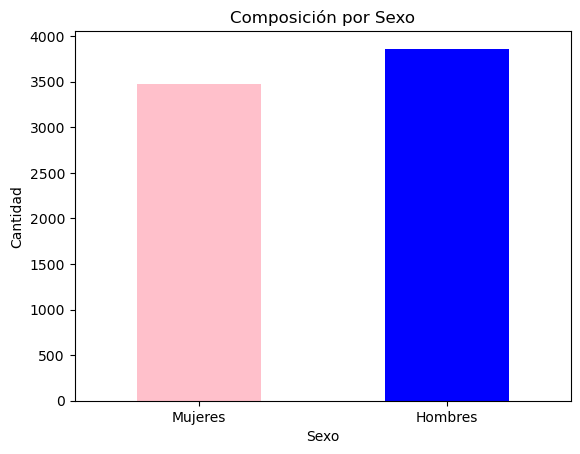

In [22]:
#c)
# Graficamos la composición por sexo
sexo_composicion = df['CH04'].value_counts().sort_index()
sexo_composicion.plot(kind='bar', color=['pink', 'blue']) 
plt.title('Composición por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Cantidad')
plt.xticks(ticks=[0, 1], labels=['Mujeres', 'Hombres'], rotation=0)

plt.show()

[Text(0.5, 0, 'CH04'),
 Text(1.5, 0, 'CH07'),
 Text(2.5, 0, 'CH08'),
 Text(3.5, 0, 'NIVEL_ED'),
 Text(4.5, 0, 'ESTADO'),
 Text(5.5, 0, 'CAT_INAC'),
 Text(6.5, 0, 'IPCF')]

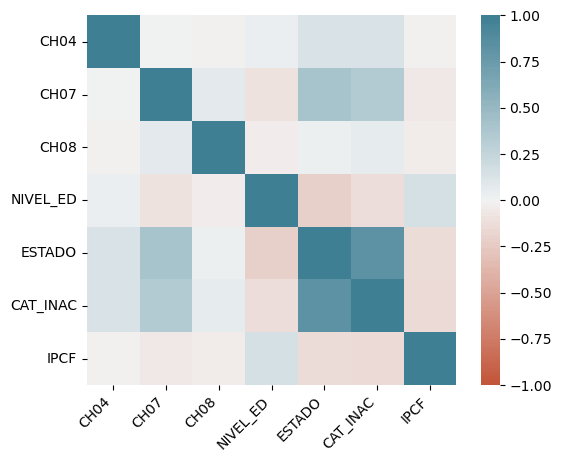

In [23]:
#d) Correlograma
import seaborn as sns
data_corr = df[['CH04','CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF']]
corr = data_corr.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [24]:
#e) Desocupado, inactivos

desocupados = len(df[df['ESTADO']==2])
inactivos = len(df[df['ESTADO']==3])

print('Cantidad de desocupados:', desocupados)
print('Cantidad de inactivos:', inactivos)

#Eliminamos todas las variables que no tengan Estado de desocupado o inactivo
des_in = df[(df['ESTADO'] == 1) | (df['ESTADO']==2) | (df['ESTADO'] == 3)]

estado_ipcf = des_in.groupby('ESTADO')['IPCF'].mean().reset_index()

print(estado_ipcf)

Cantidad de desocupados: 240
Cantidad de inactivos: 2765
   ESTADO           IPCF
0       1  132041.486499
1       2   58012.198417
2       3   84993.676882


In [25]:
#f) Necesidades Energeticas

df_adulto = pd.read_excel("C:/Users/tomas/Documents/UdeSA/Cuarto Año/Primer Cuatri/Big Data/TP3/tabla_adulto_equiv.xlsx")

#Creamos dummies por cada combinacion grupo/genero

bins = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 29, 45, 60, 75, float('inf')]
labels = [
    'less_than_1', '1_year', '2_year', '3_year', '4_year', '5_year', '6_year', '7_year', '8_year', '9_year', '10_year', 
    '11_year', '12_year', '13_year', '14_year', '15_year', '16_year', '17_year', '18_to_29', '30_to_45', 
    '46_to_60', '61_to_75', 'more_than_75'
]

df['age_group'] = pd.cut(df['CH06'], bins=bins, labels=labels)

#Dummie por genero y edad
for sex in [1, 2]:
    for label in labels:
        dummy_name = f'sex_{sex}_age_{label}'
        df[dummy_name] = ((df['CH04'] == sex) & (df['age_group'] == label)).astype(int)
        
    

In [26]:
#Mapeo de necesidades energeticas segun edad y genero
energy_needs = {
    'less_than_1': {1: 0.35, 2: 0.35},
    '1_year': {1: 0.37, 2: 0.37},
    '2_year': {1: 0.46, 2: 0.46},
    '3_year': {1: 0.51, 2: 0.51},
    '4_year': {1: 0.55, 2: 0.55},
    '5_year': {1: 0.60, 2: 0.60},
    '6_year': {1: 0.64, 2: 0.64},
    '7_year': {1: 0.66, 2: 0.66},
    '8_year': {1: 0.68, 2: 0.68},
    '9_year': {1: 0.69, 2: 0.69},
    '10_year': {1: 0.79, 2: 0.70},
    '11_year': {1: 0.82, 2: 0.72},
    '12_year': {1: 0.85, 2: 0.74},
    '13_year': {1: 0.90, 2: 0.76},
    '14_year': {1: 0.96, 2: 0.76},
    '15_year': {1: 1.00, 2: 0.77},
    '16_year': {1: 1.03, 2: 0.77},
    '17_year': {1: 1.04, 2: 0.77},
    '18_to_29': {1: 1.02, 2: 0.76},
    '30_to_45': {1: 1.00, 2: 0.77},
    '46_to_60': {1: 1.00, 2: 0.76},
    '61_to_75': {1: 0.83, 2: 0.67},
    'more_than_75': {1: 0.74, 2: 0.63}
}

In [27]:
#Cambiar valor 1 de dummie por valor energetico correspondiente a esa categoria
for sex in [1, 2]:
    for label in labels:
        dummy_name = f'sex_{sex}_age_{label}'
        energy_value = energy_needs[label][sex]
        df[dummy_name] = df[dummy_name] * energy_value


In [28]:
#Nos quedamos con los valores de necesidad energetica en una nueva variable y eliminamos las dummies
def get_positive_energy_value(row):
    for sex in [1, 2]:
        for label in labels:
            dummy_name = f'sex_{sex}_age_{label}'
            if row[dummy_name] > 0:
                return row[dummy_name]
    return 0

#df['necesidades_energeticas'] = df.apply(get_positive_energy_value, axis=1)
df['adulto_equiv'] = df.apply(get_positive_energy_value, axis=1)

df = df.loc[:, ~df.columns.str.startswith('sex_')]

df.drop(columns=['age_group'], inplace=True)



In [29]:
#Agrupamos por hogar CODUSU 
 
df['ad_equiv_hogar'] = df.groupby('CODUSU')['adulto_equiv'].transform('sum')

In [53]:
# Ejercicio 3: separamos la base en dos (respondieron, norespondieron)

cant_noresponden = len(df[df['ITF']<= 0])

print('Cantidad de personas que no respondieron su ITF:', cant_noresponden)

respondieron = df[df['ITF'] > 0].copy()

norespondieron = df[df['ITF'] <= 0].copy()

Cantidad de personas que no respondieron su ITF: 2965


In [54]:
#Ejercicio 4: Ingreso necesario
respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar']*132853.3 

In [55]:
#Ejercicio 5: Calculamos cantidad de pobres 

respondieron['pobre'] = np.where(respondieron['ingreso_necesario'] > respondieron['ITF'], 1, 0)

pobres = respondieron['pobre'].sum()

print('Total de pobres:', pobres)

Total de pobres: 1750


In [64]:
### Parte II ##: 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score


# 1
cols_ingreso = ['CODUSU', 'ITF', 'IPCF', 'PP06C', 'PP06D', 'PP08D1',  'P21', 'TOT_P12', 
                'P47T', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M',
                'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V21_M', 'T_VI', 
                'adulto_equiv', 'ad_equiv_hogar', 'CH05', 'PP09A_ESP',
                'DECINDR', 'ADECINDR', 'RDECINDR', 'PDECINDR', 'GDECINDR', 'IDECINDR',
                'DECOCUR','ADECOCUR','RDECOCUR','PDECOCUR','GDECOCUR','IDECOCUR',
                'DECIFR','ADECIFR','RDECIFR','PDECIFR','GDECIFR','IDECIFR','DECCFR',
                'ADECCFR','RDECCFR','PDECCFR','GDECCFR','IDECCFR'
                ]

df_res = respondieron.drop(columns = cols_ingreso + ['ingreso_necesario'])
df_res = df_res.dropna(axis=1)
df_nores = norespondieron.drop(columns = cols_ingreso)
df_nores = df_nores.dropna(axis=1)



In [65]:
# 2
X = df_res.drop(columns=['pobre'])  
X['intercept'] = 1 
y = df_res['pobre'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [66]:
# 3 Logit 
# Ajustamos el clasificador con el método fit() 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)  # Fit scaler on training data only
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(penalty=None, max_iter=1000)  # Set penalty and increase iterations (optional)
log_reg.fit(X_train_scaled, y_train)

y_test_pred_score = log_reg.predict_proba(X_test_scaled)[:, 1]
y_train_pred_score = log_reg.predict_proba(X_train_scaled)[:, 1]
y_test_pred = (y_test_pred_score >= 0.5).astype(int)

Matriz de Confusión:
 [[645 142]
 [214 310]]
Accuracy: 0.7284515636918383


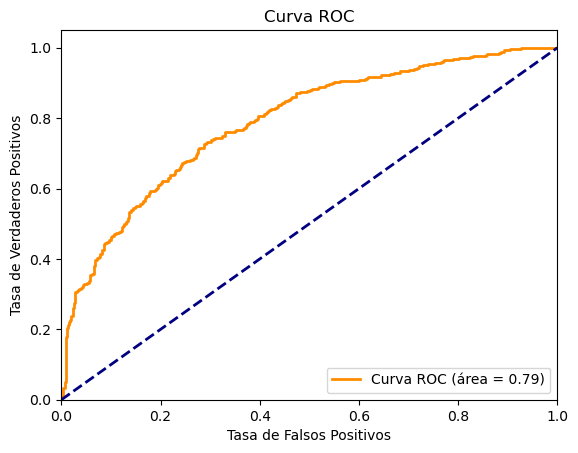

In [67]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Matriz de Confusión:\n", conf_matrix)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_score)
roc_auc = auc(fpr, tpr)

# Calcular la precisión (accuracy)
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", accuracy)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [68]:
#K-Nearest Neighbors

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

y_test_pred = knn.predict(X_test_scaled) 


In [69]:
# Medidas de precision
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Matriz de Confusión:\n", conf_matrix)

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

print("AUC del ROC:", roc_auc)  # AUC of ROC curve

accuracy = accuracy_score(y_test, y_test_pred)
print("Precisión (Accuracy):", accuracy)

Matriz de Confusión:
 [[616 171]
 [217 307]]
AUC del ROC: 0.6842985246903402
Precisión (Accuracy): 0.704042715484363


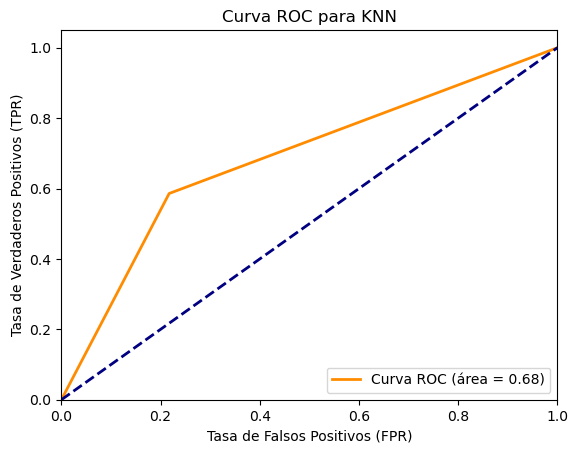

In [70]:
#Grafico ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para KNN')
plt.legend(loc="lower right")
plt.show()


In [71]:
# 5 - Clasificar a individuos que no reportaron su ingreso usando modelo Logit entrenado con la base de los que si respondieron
df_nores['intercept'] = 1

df_nores_scaled = scaler.transform(df_nores)

df_nores_pred_score = log_reg.predict_proba(df_nores_scaled)[:, 1]
df_nores['pobre'] = (df_nores_pred_score >= 0.5).astype(int)

pobres_predict = df_nores['pobre'].sum()

print('Total de pobres:', pobres_predict)

Total de pobres: 1723


In [ ]:
# Ejercicio 6 - Logit con cantidad de variables reducidas

df_res_6 = df_res[['pobre', 'MAS_500', 'CH06', 'CH07', 'CH08', 'CH09', 'CH10', 'CH11', 'CH12', 'CH13', 'CH15', 'NIVEL_ED', 'ESTADO', 'CAT_OCUP']]

X = df_res_6.drop(columns=['pobre'])  
X['intercept'] = 1 
y = df_res_6['pobre'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

scaler.fit(X_train)  
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(penalty=None, max_iter=1000)  
log_reg.fit(X_train_scaled, y_train)

y_test_pred_score = log_reg.predict_proba(X_test_scaled)[:, 1]
y_train_pred_score = log_reg.predict_proba(X_train_scaled)[:, 1]
y_test_pred = (y_test_pred_score >= 0.5).astype(int)

In [ ]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Matriz de Confusión:\n", conf_matrix)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_score)
roc_auc = auc(fpr, tpr)

print(roc_auc)

# Calcular la precisión (accuracy)
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", accuracy)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()